# Modeling CB1 ligands

In [2]:
#Load libraries
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn import ensemble
from sklearn import model_selection as ms
from sklearn.metrics import mean_squared_error
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from matplotlib import pyplot
import seaborn
import pandas as pd
import numpy as np
import csv
import re

RDKit WARNING: [20:33:37] Enabling RDKit 2019.09.3 jupyter extensions


## Cleaning data

In [3]:
#Standardization of our compounds to get rid off salts and inorganics etc.
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [4]:
#Standadization of our compounds to remove salts and inorganics etc.
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]")
_carbonPatt = Chem.MolFromSmarts("[#6]")
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                Chem.SanitizeMol(mol)
                return mol
    else:
        return None

# Load data

In [5]:
#Load cannabinoid dataset
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")
lip_func = [("HBA", Lipinski.NumHAcceptors), ("HBD", Lipinski.NumHDonors), ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), ("TPSA", rdMolDescriptors.CalcTPSA), ("RB", Lipinski.NumRotatableBonds)]
with open("cannabinoid.csv") as inp:
    can = [row for row in csv.DictReader(inp, delimiter=";", quotechar='"')]
    for m in can:
        mol = Chem.MolFromSmiles(m["Smiles"])
        if mol:
            m["rdmol"] = mol
            stdmol = standardize(mol)
            m["source"] = "can"
            m["pChEMBL Value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else 0
            m["std_rdmol"] = None
            m["Standard Value"] = float(m["Standard Value"]) if float_pattern.match(m["Standard Value"]) else np.NaN
        if stdmol:
            m["std_rdmol"] = stdmol
            m["std_smiles"] = Chem.MolToSmiles(stdmol)
            m["fps"] = Chem.GetMorganFingerprintAsBitVect(m["std_rdmol"],2,nBits=1024)
            for f in lip_func:
                m[f[0]] = f[1](m["std_rdmol"])

In [6]:
%%capture
#Load drugbank data
drugbank = []
for m in Chem.SDMolSupplier("../data/drugbank.sdf"):
    if m:
        stdmol = standardize(m)
    else:
        continue    
    if stdmol:
        std_smiles = Chem.MolToSmiles(stdmol)
        drugbank.append({
         "rdmol": m,
         "std_rdmol": stdmol,
         "source": "drugbank",
         "std_smiles": std_smiles,
         "Smiles": Chem.MolToSmiles(m),
         "pChEMBL Value": 0,
         "Standard Value": np.NaN,
         "fps": Chem.GetMorganFingerprintAsBitVect(stdmol, 2, nBits=1024),
         **{f[0]: f[1](stdmol) for f in lip_func}
        })

In [7]:
# Create dataframe
df = pd.DataFrame((*drugbank, *[m for m in can if m["std_rdmol"]]), columns=["Smiles", "std_smiles", "source", "rdmol", "std_rdmol", "fps", "Standard Value", "pChEMBL Value", *(f[0] for f in lip_func)])
df.reset_index(level=0, inplace=True)
df = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["std_rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )


In [8]:
df

,index,Smiles,std_smiles,source,rdmol,std_rdmol,fps,Standard Value,pChEMBL Value,HBA,...,MQN_33,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42
0,0,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x0000017CBD4...,<rdkit.Chem.rdchem.Mol object at 0x0000017CBD4...,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,0.00,29,...,0,0,3,3,0,0,0,0,0,0
1,1,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x0000017CBD4...,<rdkit.Chem.rdchem.Mol object at 0x0000017CBD4...,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,0.00,16,...,0,0,4,2,0,0,0,0,2,1
2,2,N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...,N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x0000017CBD4...,<rdkit.Chem.rdchem.Mol object at 0x0000017CBD4...,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",NaN,0.00,15,...,0,0,1,2,0,0,0,1,0,0
3,3,CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...,CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x0000017CBD4...,<rdkit.Chem.rdchem.Mol object at 0x0000017CC4F...,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,0.00,16,...,0,0,1,5,0,0,0,0,2,1
4,4,C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...,C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x0000017CC3F...,<rdkit.Chem.rdchem.Mol object at 0x0000017CC4F...,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",NaN,0.00,12,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9125,9125,O=S(=O)(NCc1ccc(-c2ccccc2)cc1)c1cc2cc(Br)ccc2[...,O=S(=O)(NCc1ccc(-c2ccccc2)cc1)c1cc2cc(Br)ccc2[...,can,<rdkit.Chem.rdchem.Mol object at 0x0000017CC60...,<rdkit.Chem.rdchem.Mol object at 0x0000017CC60...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.0,8.22,2,...,0,0,1,3,0,0,0,0,2,1
9126,9126,CCc1c(S(=O)(=O)NCCc2ccc(N3CCOCC3)cc2)[nH]c2ccc...,CCc1c(S(=O)(=O)NCCc2ccc(N3CCOCC3)cc2)[nH]c2ccc...,can,<rdkit.Chem.rdchem.Mol object at 0x0000017CC60...,<rdkit.Chem.rdchem.Mol object at 0x0000017CC60...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",500.0,6.30,4,...,0,0,1,3,0,0,0,0,2,1
9127,9127,Cc1c(S(=O)(=O)NCc2ccccc2)[nH]c2ccccc12,Cc1c(S(=O)(=O)NCc2ccccc2)[nH]c2ccccc12,can,<rdkit.Chem.rdchem.Mol object at 0x0000017CC60...,<rdkit.Chem.rdchem.Mol object at 0x0000017CC5F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1000.0,0.00,2,...,0,0,1,2,0,0,0,0,2,1
9128,9128,O=C(Nc1ccc(Cl)cc1)Nc1ccc(-c2ccccc2)s1,O=C(Nc1ccc(Cl)cc1)Nc1ccc(-c2ccccc2)s1,can,<rdkit.Chem.rdchem.Mol object at 0x0000017CC5F...,<rdkit.Chem.rdchem.Mol object at 0x0000017CC50...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.8,8.17,2,...,0,0,1,2,0,0,0,0,0,0


In [86]:
mx = df["Standard Value"].max()+1
df["Standard Value"] = df["Standard Value"].fillna(mx+1)

In [87]:
#SVR
svr = svm.SVR()
svr.fit(df[df["Standard Value"]<mx][(f"MQN_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["Standard Value"])

SVR()

In [88]:
res = pd.DataFrame(svr.predict(df[(f"MQN_{x}" for x in range(1, 43))])).join(df[["Standard Value", "source"]])
res.columns = ["Prediction", "Standard Value", "Source"]
(res["Prediction"]-res["Standard Value"]).abs().mean()

7702921.360485191

In [89]:
(res[res["Source"]=="can"]["Prediction"]-res[res["Source"]=="can"]["Standard Value"]).abs().mean()

2965108.8692580583

In [90]:
#Functions to get results
def get_results(model, data, descriptors, predicted_value):
    res = pd.DataFrame(model.predict(data[descriptors])).join(data[[predicted_value, "source"]])
    res.columns = ["Prediction", predicted_value, "Source"]
    print(f"""Average error whole set: {(res["Prediction"]-res[predicted_value]).abs().mean()}
Average error cannabinoids: {(res[res["Source"]=="can"]["Prediction"]-res[res["Source"]=="can"][predicted_value]).abs().mean()}""")
    return res

In [91]:
res = get_results(svr, df, (f"MQN_{x}" for x in range(1, 43)), "Standard Value")

Average error whole set: 7702921.360485191
Average error cannabinoids: 2965108.8692580583


# Graphs

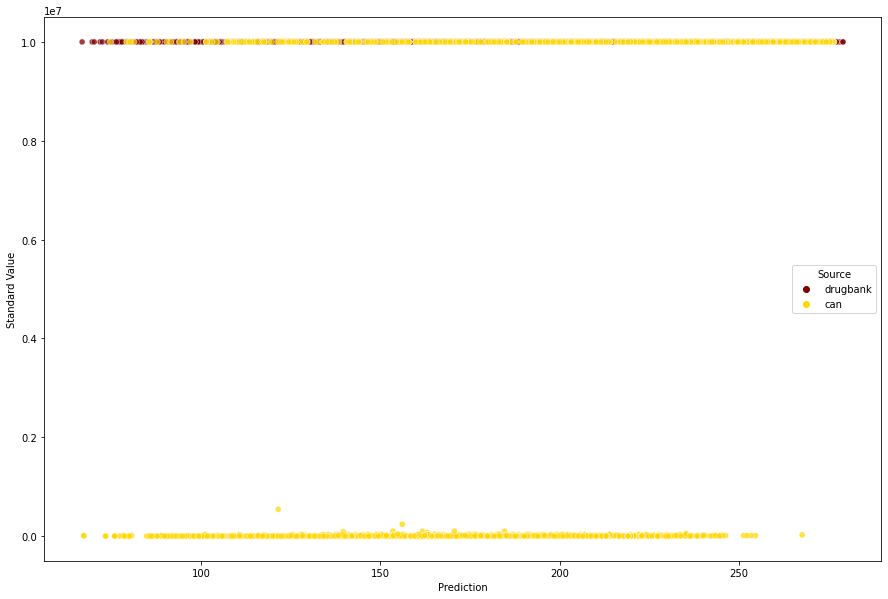

In [92]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res,
                      hue="Source",
                      legend="brief",
                      palette=['maroon','gold'],
                      ax=ax,
                      alpha=0.75
                     )


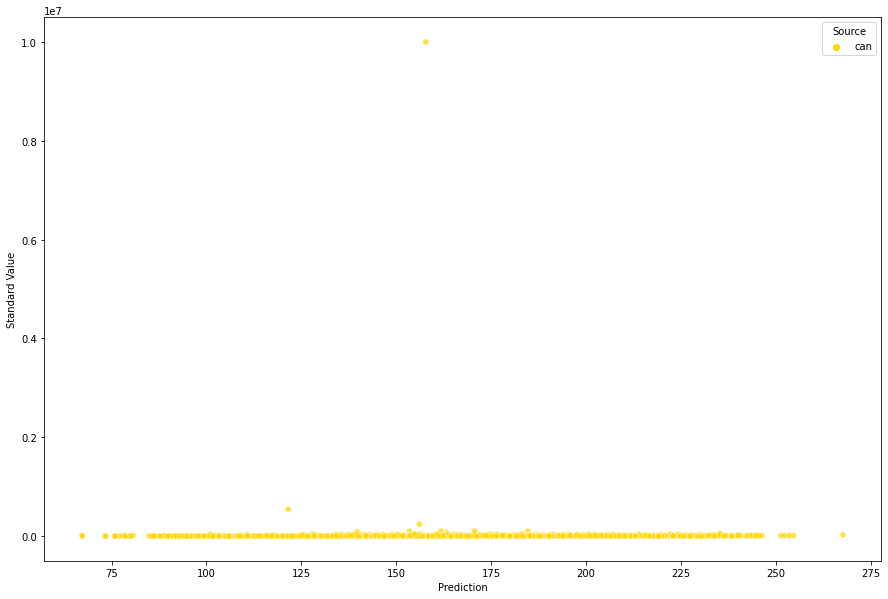

In [93]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res[res["Standard Value"]<mx],
                      hue="Source",
                      legend="brief",
                      palette= ['gold'],
                      ax=ax,
                      alpha=0.75
                     )

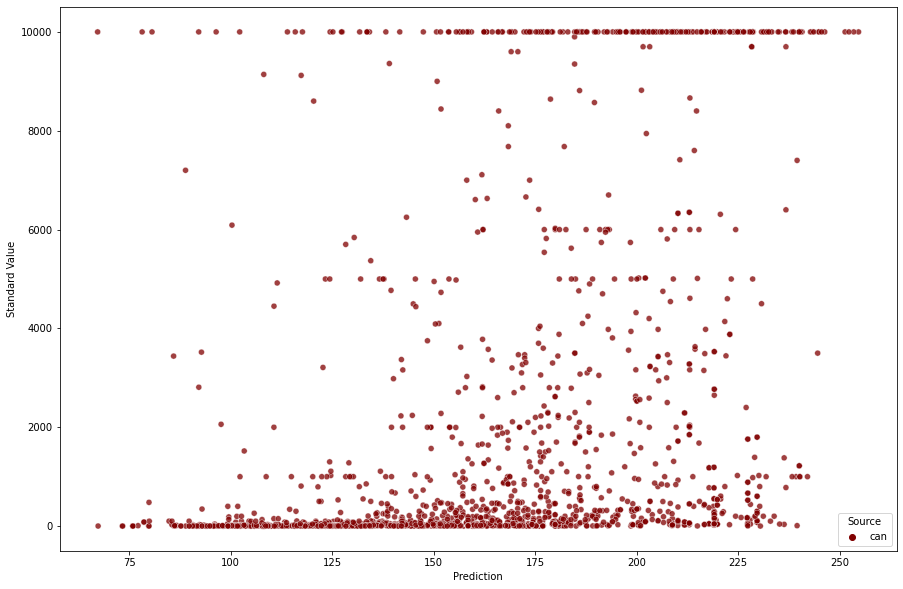

In [94]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res[res["Standard Value"]<mx/1000],
                      hue="Source",
                      legend="brief",
                      palette= ['maroon'],
                      ax=ax,
                      alpha=0.75
                     )

# Random forest

In [95]:
#Use Random forest regression
rf = ensemble.RandomForestRegressor()
rf.fit(df[df["Standard Value"]<mx][(f"MQN_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["Standard Value"])

RandomForestRegressor()

In [96]:
#Get result
res_rf = get_results(rf, df, (f"MQN_{x}" for x in range(1, 43)), "Standard Value")

Average error whole set: 7593285.031217144
Average error cannabinoids: 2927356.6203049


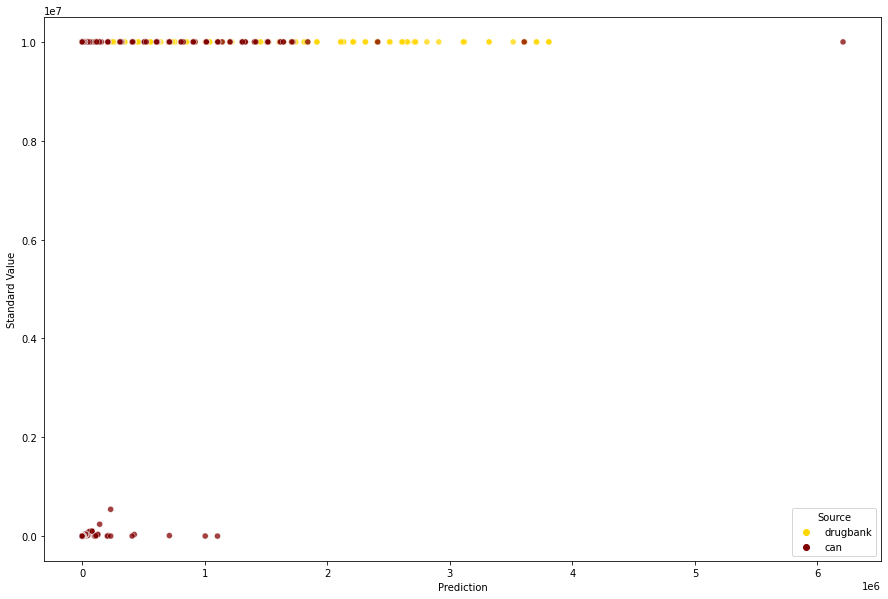

In [97]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res_rf,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                    palette= ['gold', 'maroon'],
                      alpha=0.75
                     )

C:\Users\katka\anaconda3\envs\cdd\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


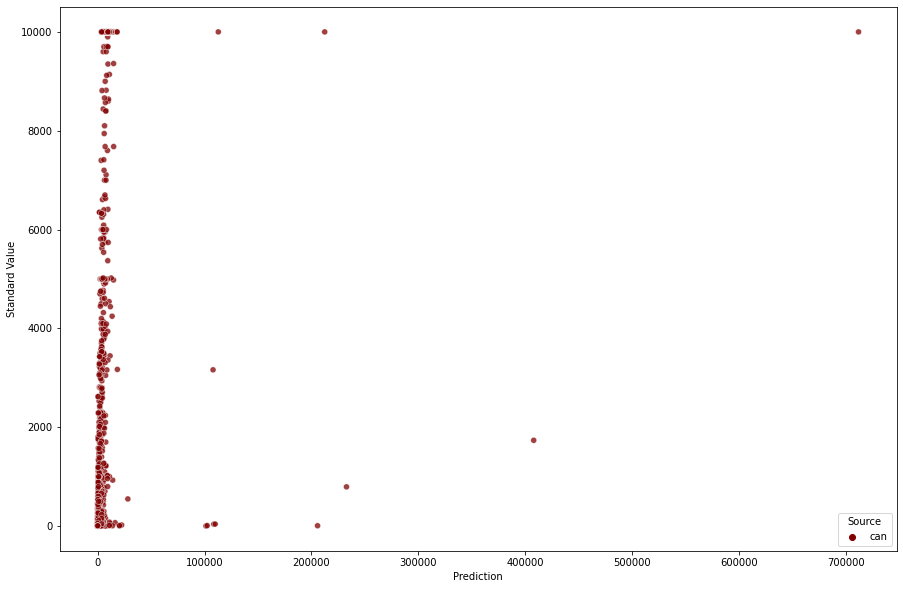

In [98]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res_rf[res_rf["Standard Value"]<mx/1000][res_rf["Prediction"]<1e6],
                      hue="Source",
                      legend="brief",
                      palette= ['maroon'],
                      ax=ax,
                      alpha=0.75
                     )

#  SVR

In [99]:
#Use SVR
svr_p = svm.SVR()
svr_p.fit(df[df["pChEMBL Value"]>0][(f"MQN_{x}" for x in range(1, 43))], df[df["pChEMBL Value"]>0]["pChEMBL Value"])

SVR()

In [100]:
res_svr_p = get_results(svr_p, df, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 4.883939613162507
Average error cannabinoids: 3.013213361147357


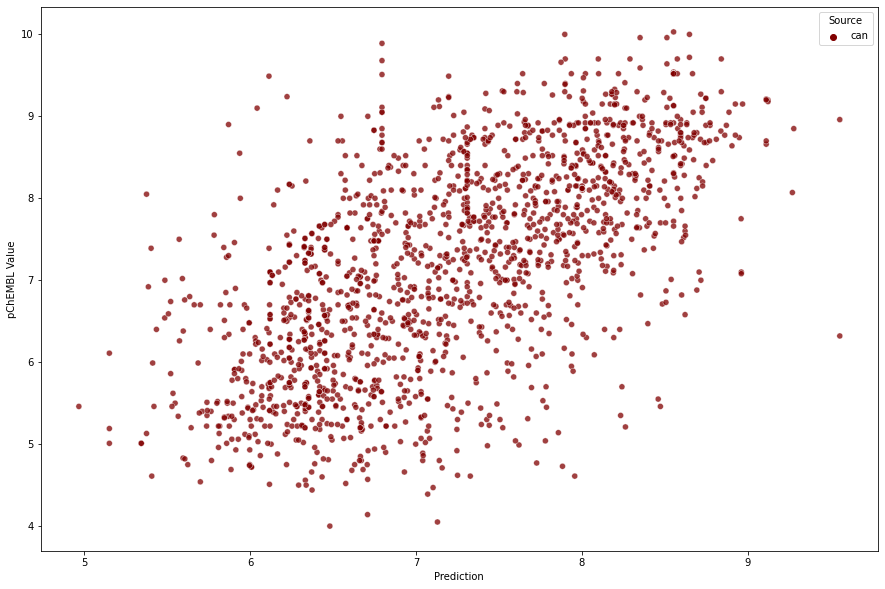

In [101]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=res_svr_p[res_svr_p["pChEMBL Value"]>0],
                      hue="Source",
                      legend="brief",
                    palette= ['maroon'],
                      ax=ax,
                      alpha=0.75
                     )

# SVR with PCA

In [102]:
#Normalize data and use principal component analysis
norm = preprocessing.normalize(df[(f"MQN_{x}" for x in range(1, 43))])
pca = decomposition.PCA(n_components=42)
pca.fit(norm)
df = df.join(pd.DataFrame(pca.transform(norm), columns=[f"nPCA_{x}" for x in range(1, 43)]))

In [103]:
svr_np = svm.SVR()
svr_np.fit(df[df["Standard Value"]<mx][(f"nPCA_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["pChEMBL Value"])

SVR()

In [104]:
#Get results for svr
res_svr_np = res = get_results(svr_np, df, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 2.9457873797081637
Average error cannabinoids: 2.0386863689726242


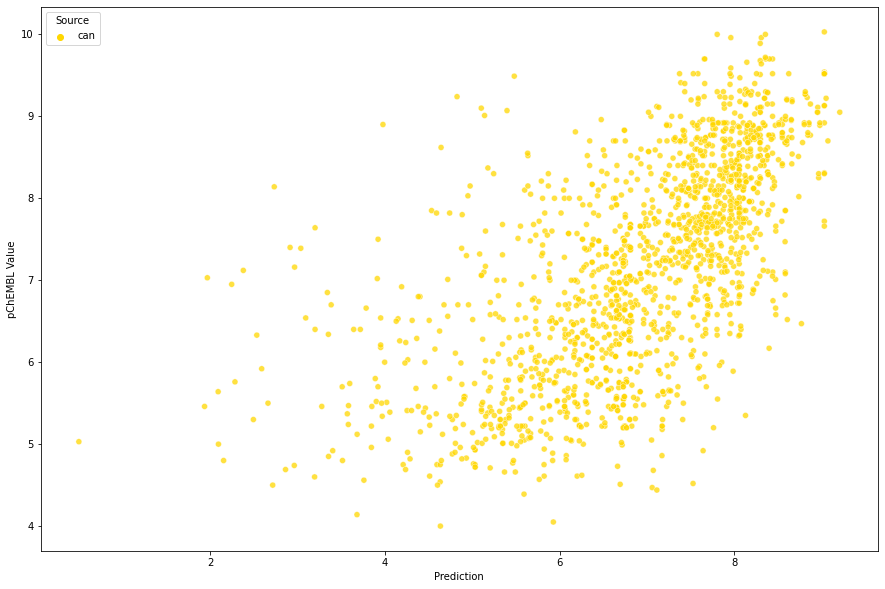

In [105]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=res_svr_np[res_svr_np["pChEMBL Value"]>0],
                      hue="Source",
                      legend="brief",
                      palette= ['gold'],
                      ax=ax,
                      alpha=0.75
                     )

In [106]:
svr_poly = svm.SVR(kernel='poly')
svr_poly.fit(df[df["Standard Value"]<mx][(f"nPCA_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["pChEMBL Value"])

SVR(kernel='poly')

In [107]:
res_poly = get_results(svr_poly, df, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 5.522501430037836
Average error cannabinoids: 3.008494538946079


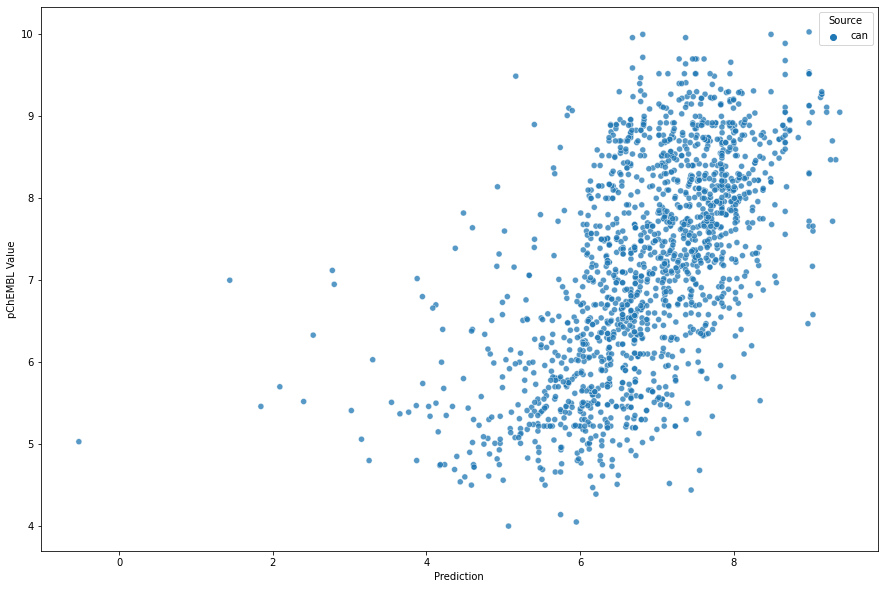

In [108]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=res_poly[res_poly["pChEMBL Value"]>0],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

# Split data

In [109]:
#Split data
trainset, testset = ms.train_test_split(df[df["pChEMBL Value"]>0])

In [110]:
trainset.reset_index(inplace=True)
testset.reset_index(inplace=True)

In [111]:
#Check out lenght
len(trainset), len(testset)

(1273, 425)

In [112]:
finaly_good_model = ensemble.RandomForestRegressor()
finaly_good_model.fit(trainset[(f"MQN_{x}" for x in range(1, 43))], trainset["pChEMBL Value"])

RandomForestRegressor()

In [113]:
train_results = get_results(finaly_good_model, trainset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.28751747706858993
Average error cannabinoids: 0.28751747706858993


In [114]:
test_results = get_results(finaly_good_model, testset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.6399648976860793
Average error cannabinoids: 0.6399648976860793


In [115]:
print("R^2: %0.2f" % finaly_good_model.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL Value"]))
print("R: %0.2f" % np.sqrt(finaly_good_model.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL Value"])))
print("MSE: %0.2f" %  mean_squared_error(test_results["Prediction"], test_results["pChEMBL Value"]))

R^2: 0.56
R: 0.75
MSE: 0.71


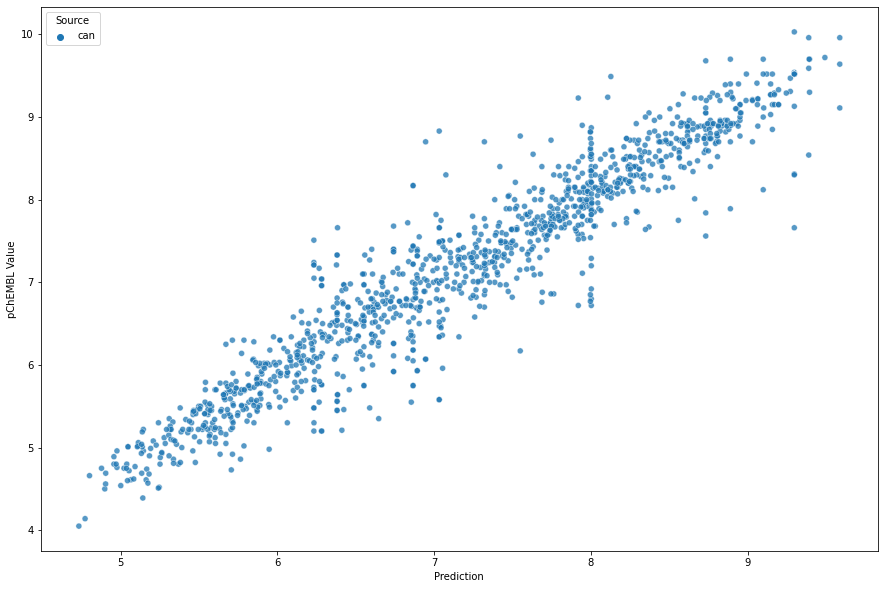

In [116]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=train_results,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

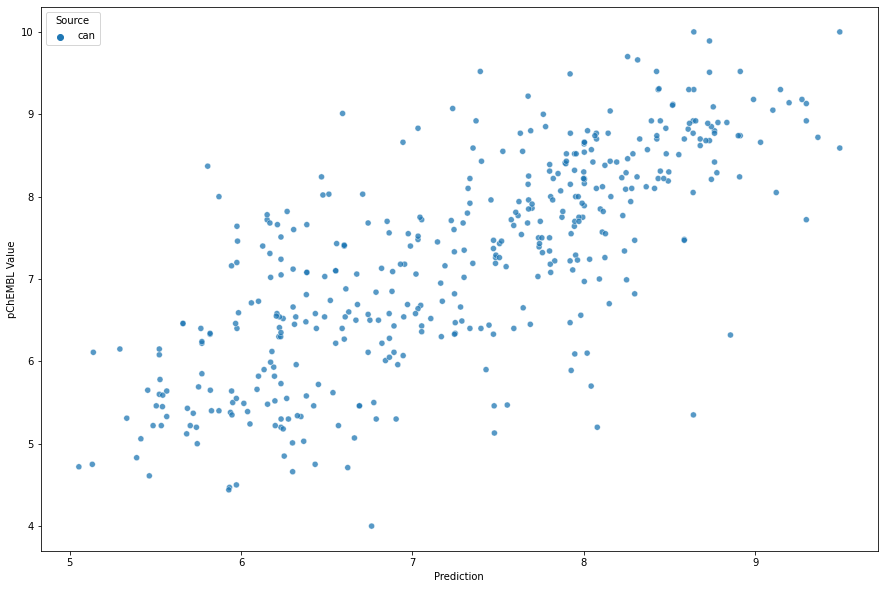

In [117]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=test_results,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

# Results
So, we tried to predict activity on cannabinoid ligands. For this exercise we used regresion methods SVM and Random Forest. 
One of the best results were achieved using SVR with PCA were average error was 2.038. However, the lowest error on cannabinoid dataset was achieved while spliting data to train and test dataset and using Random forest. The average error in this case was 0.64. So, the Random Forest come as the best prediciton tool for our dataset.